<a href="https://colab.research.google.com/github/Mursithrosan27/AI-Diabates/blob/main/stock%26sentiment_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install yfinance -q

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

In [ ]:
%load_ext lab_black

In [12]:
msft = yf.Ticker("MSFT")

In [13]:
hist = msft.history(period="max")

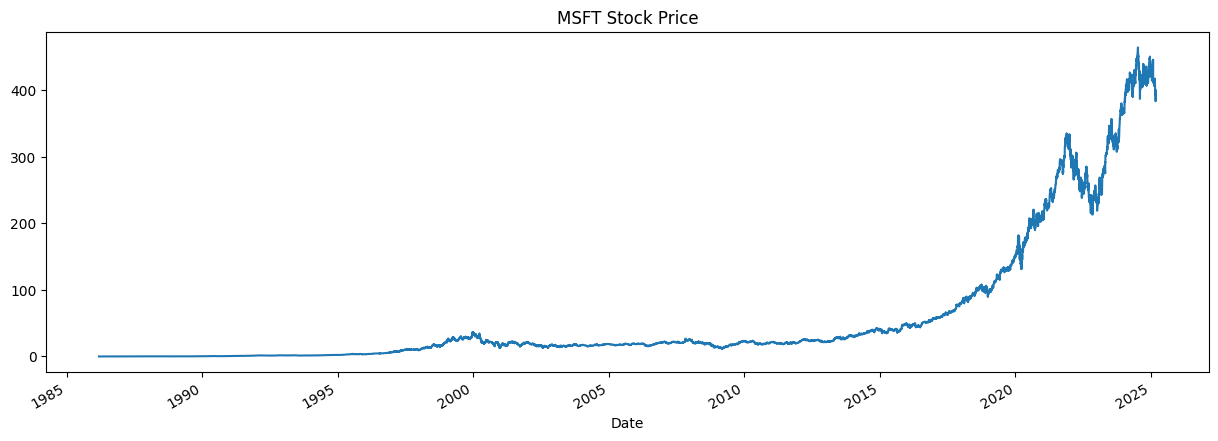

In [14]:
hist["Open"].plot(figsize=(15, 5), title="MSFT Stock Price")
plt.show()

In [17]:
stonks = [
    "^GSPC",
    "ETSY",
    "PINS",
    "SQ",
    "SHOP",
    "O",
    "MELI",
    "ISRG",
    "DIS",
    "BRK-B",
    "AMZN",
    "ZM",
    "PFE",
    "CLX",
    "DPZ",
    "RTX",
    "MRF.NS",
]

In [18]:
hists = {}
for s in stonks:
    tkr = yf.Ticker(s)
    history = tkr.history(period="3y")
    hists[s] = history

In [19]:
for stock in stonks:
    temp_df = hists[stock].copy()

    fig = go.Figure(
        data=[
            go.Candlestick(
                x=temp_df.index,
                open=temp_df["Open"],
                high=temp_df["High"],
                low=temp_df["Low"],
                close=temp_df["Close"],
            )
        ]
    )

    fig.update_layout(
        margin=dict(l=20, r=20, t=60, b=20),
        height=300,
        paper_bgcolor="LightSteelBlue",
        title=stock,
    )

    fig.show()

In [21]:
hists["MRF.NS"].index.min()

Timestamp('2022-03-07 00:00:00+0530', tz='Asia/Kolkata')

In [23]:
stock = "MRF.NS"

In [24]:
from serpapi import GoogleSearch
import pandas as pd
from tqdm.notebook import tqdm

# Define stock symbol
stock = "MRF"  # Change this to any stock symbol you want

# Creating list to store news data
news_list = []

# Search parameters for SerpApi
params = {
    "engine": "google_news",   # Use Google News engine
    "q": f"{stock} stock",     # Search query
    "api_key": "aedc42f1b5190cd16a5f09cdf97b75fd8ece98547340104b37d5fee2c40d7365",  # Replace with your SerpApi key
    "hl": "en",                # Language
    "gl": "US"                 # Country
}

# Fetch news articles using SerpApi
search = GoogleSearch(params)
results = search.get_dict()

# Extract and store news data
if "news_results" in results:
    for i, news in tqdm(enumerate(results["news_results"]), total=len(results["news_results"])):
        news_list.append([
            news.get("date"),
            news.get("title"),
            news.get("link"),
            news.get("source", {}).get("name")  # Get the news source name
        ])

# Creating a DataFrame
news_df = pd.DataFrame(news_list, columns=["Datetime", "Title", "URL", "Source"])

# Display DataFrame
print(news_df)

  0%|          | 0/99 [00:00<?, ?it/s]

                           Datetime  \
0   08/13/2024, 07:00 AM, +0000 UTC   
1   02/13/2025, 08:00 AM, +0000 UTC   
2   02/28/2025, 12:42 AM, +0000 UTC   
3   02/13/2025, 08:00 AM, +0000 UTC   
4   02/28/2025, 12:00 PM, +0000 UTC   
..                              ...   
94  02/06/2025, 08:00 AM, +0000 UTC   
95  02/06/2025, 08:00 AM, +0000 UTC   
96  02/13/2025, 09:15 AM, +0000 UTC   
97  11/18/2024, 08:00 AM, +0000 UTC   
98  12/20/2024, 08:00 AM, +0000 UTC   

                                                Title  \
0                 Why Is The MRF Share Price So High?   
1   MRF shares to trade ex-dividend on Friday. Do ...   
2   MRF Limited's (NSE:MRF) latest 3.8% decline ad...   
3   Dividend stocks: MRF, Balco, REC, Gulf Oil, 23...   
4   MRF Outlook for the Week (March 03, 2025 – Mar...   
..                                                ...   
94  MRF shares tank as Q3 profit drops 38 pc, firm...   
95  Sensex Today | Stock Market Highlights: Sensex...   
96  Dividend, Bonu

In [25]:
# Save DataFrame to a Parquet file
news_df.to_parquet("clx_news.parquet", engine="pyarrow")

In [26]:
from transformers import pipeline

model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_task = pipeline("sentiment-analysis", model=model)
sentiment_task("Covid cases are increasing fast!")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'label': 'negative', 'score': 0.7235763669013977}]

In [27]:
sent_results = {}
count = 0

# Iterate through news articles
for i, d in tqdm(news_df.iterrows(), total=len(news_df)):
    sent = sentiment_task(d["Title"])  # Perform sentiment analysis on the news title
    sent_results[d["URL"]] = sent  # Store results using the article URL as the key
    count += 1
    if count == 500:  # Stop after processing 500 articles
        break

  0%|          | 0/99 [00:00<?, ?it/s]

In [28]:
# Convert sentiment results dictionary to DataFrame
sent_df = pd.DataFrame(sent_results).T  # Transpose to align data properly

# Extract sentiment label and score
sent_df["label"] = sent_df[0].apply(lambda x: x["label"])
sent_df["score"] = sent_df[0].apply(lambda x: x["score"])

# Merge with news DataFrame using URL as the index
sent_df = sent_df.merge(news_df.set_index("URL"), left_index=True, right_index=True)

# Display the final DataFrame
print(sent_df.head())

                                                                                                    0  \
https://www.forbes.com/advisor/in/investing/why...  {'label': 'negative', 'score': 0.5213592052459...   
https://m.economictimes.com/markets/stocks/news...  {'label': 'neutral', 'score': 0.9527521133422852}   
https://simplywall.st/stocks/in/automobiles/nse...  {'label': 'negative', 'score': 0.7604148387908...   
https://www.business-standard.com/markets/news/...  {'label': 'neutral', 'score': 0.8377541303634644}   
https://www.equitypandit.com/mrf-outlook-for-th...  {'label': 'neutral', 'score': 0.9021760821342468}   

                                                       label     score  \
https://www.forbes.com/advisor/in/investing/why...  negative  0.521359   
https://m.economictimes.com/markets/stocks/news...   neutral  0.952752   
https://simplywall.st/stocks/in/automobiles/nse...  negative  0.760415   
https://www.business-standard.com/markets/news/...   neutral  0.837754   

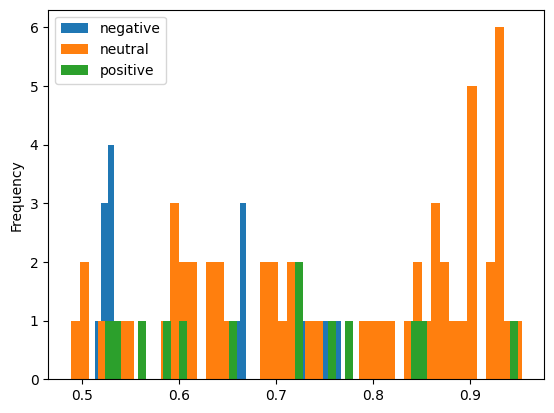

In [29]:
sent_df.groupby("label")["score"].plot(kind="hist", bins=50)
plt.legend()
plt.show()

In [30]:
# Create a new column for adjusted sentiment scores
sent_df["score_"] = sent_df["score"]

# Convert negative sentiment scores to negative values
sent_df.loc[sent_df["label"] == "Negative", "score_"] *= -1

# Set neutral sentiment scores to 0
sent_df.loc[sent_df["label"] == "Neutral", "score_"] = 0

# Display the updated DataFrame
print(sent_df.head())

                                                                                                    0  \
https://www.forbes.com/advisor/in/investing/why...  {'label': 'negative', 'score': 0.5213592052459...   
https://m.economictimes.com/markets/stocks/news...  {'label': 'neutral', 'score': 0.9527521133422852}   
https://simplywall.st/stocks/in/automobiles/nse...  {'label': 'negative', 'score': 0.7604148387908...   
https://www.business-standard.com/markets/news/...  {'label': 'neutral', 'score': 0.8377541303634644}   
https://www.equitypandit.com/mrf-outlook-for-th...  {'label': 'neutral', 'score': 0.9021760821342468}   

                                                       label     score  \
https://www.forbes.com/advisor/in/investing/why...  negative  0.521359   
https://m.economictimes.com/markets/stocks/news...   neutral  0.952752   
https://simplywall.st/stocks/in/automobiles/nse...  negative  0.760415   
https://www.business-standard.com/markets/news/...   neutral  0.837754   

<Axes: ylabel='Frequency'>

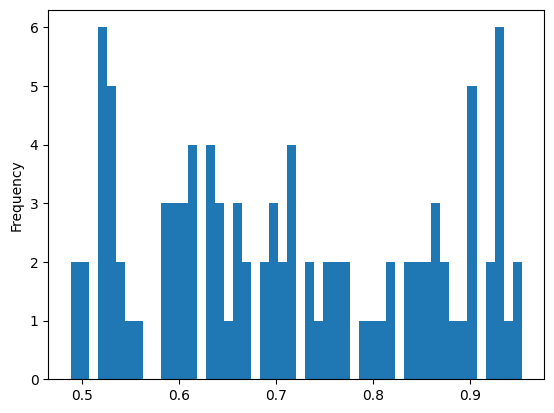

In [32]:
sent_df["score_"].plot(kind="hist", bins=50)

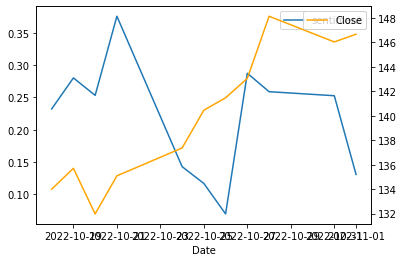

In [ ]:
sent_df["Date"] = sent_df["Datetime"].dt.date

sent_daily = sent_df.groupby("Date")["score_"].mean()

clx_df = hists["CLX"].copy()
clx_df = clx_df.reset_index()
clx_df["Date"] = clx_df["Date"].dt.date
clx_df = clx_df.set_index("Date")

sent_and_stock = sent_daily.to_frame("sentiment").merge(
    clx_df, left_index=True, right_index=True
)

ax = sent_and_stock["sentiment"].plot(legend="Sentiment")
ax2 = ax.twinx()
sent_and_stock["Close"].plot(ax=ax2, color="orange", legend="Closing Price")
plt.show()

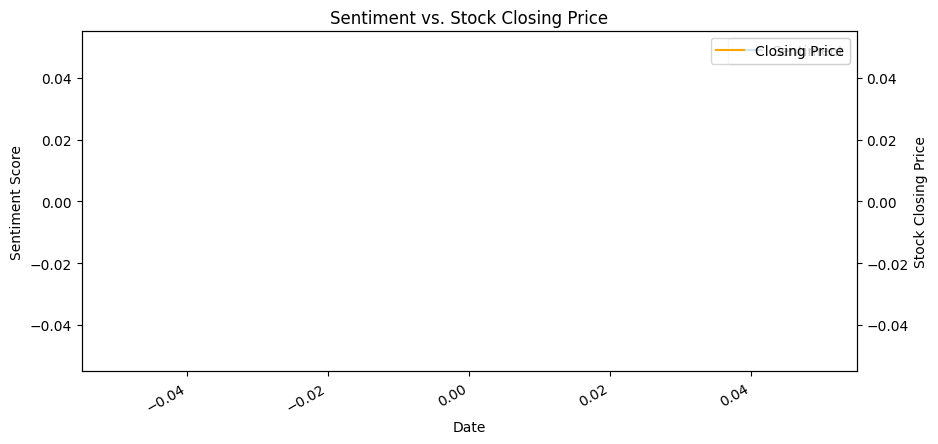

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure "Datetime" is in proper datetime format
sent_df["Datetime"] = pd.to_datetime(sent_df["Datetime"], errors="coerce")

# Convert "Datetime" to just the "Date" (dropping time)
sent_df["Date"] = sent_df["Datetime"].dt.date

# Compute daily average sentiment score
sent_daily = sent_df.groupby("Date")["score_"].mean()

# Ensure stock data is correctly formatted
mrf_df = hists["MRF.NS"].copy()  # Replace "MRF" with the correct stock symbol
mrf_df = mrf_df.reset_index()

# Convert stock "Date" to proper format
mrf_df["Date"] = pd.to_datetime(mrf_df["Date"], errors="coerce").dt.date

# Set "Date" as index for merging
mrf_df = mrf_df.set_index("Date")

# Merge sentiment scores with stock prices on "Date"
sent_and_stock = sent_daily.to_frame("sentiment").merge(
    mrf_df, left_index=True, right_index=True
)

# Plot sentiment and stock closing price
ax = sent_and_stock["sentiment"].plot(legend=True, label="Sentiment", figsize=(10, 5))
ax2 = ax.twinx()
sent_and_stock["Close"].plot(ax=ax2, color="orange", legend=True, label="Closing Price")

# Add title and labels
ax.set_ylabel("Sentiment Score")
ax2.set_ylabel("Stock Closing Price")
plt.title("Sentiment vs. Stock Closing Price")

# Show the plot
plt.show()

In [1]:
pip install google-search-results